In [1]:
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
%load_ext autoreload
%autoreload 2
import sys; 
sys.path.extend(['/home/meet/FlowMatchingTests/conditional-flow-matching/'])

import matplotlib.pyplot as plt
import numpy as np
import torch
from torchcfm.conditional_flow_matching import *
from physics_flow_matching.wall_pres.unet import UNetModel
from torchdiffeq import odeint
from einops import rearrange

In [3]:
label = np.load("/home/xiantao/case/wall_pressure/bigchannel/data/channel_180_wall_dudy.npy")
test_label = np.load("/home/xiantao/case/wall_pressure/bigchannel/data/channel_180_wall_dudy_221-259.npy")
m, std = label.mean(), label.std()
test_label = rearrange(test_label, "b l c w -> (b c) l w")
# test_label = (test_label[:, 160:])[:, None]
# Y = (label - label.mean())/label.std()

In [4]:
data = np.load("/home/xiantao/case/wall_pressure/bigchannel/data/channel_180_wall_pressure.npy")
m_, std_ = data.mean(), data.std()

test_data = np.load("/home/xiantao/case/wall_pressure/bigchannel/data/channel_180_wall_p_221-259.npy")
test_data = rearrange(test_data, "b l c w -> (b c) l w")
# test_data = (test_data[:, 160:])[:, None]
X = (test_data - m_)/std_

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
exp=4
iteration = 5
ot_cfm_model = UNetModel(dim=[1, 20, 200],
                        num_channels=128,
                        channel_mult = [1, 2, 4],
                        num_res_blocks=2,
                        num_head_channels=64,
                        attention_resolutions="40, 20",
                        dropout=0.2,
                        use_new_attention_order=True,
                        use_scale_shift_norm=True)
state = torch.load(f"/home/meet/FlowMatchingTests/conditional-flow-matching/physics_flow_matching/wp_ws/exps/bb_exps/exp_{exp}/saved_state/checkpoint_{iteration}.pth")
ot_cfm_model.load_state_dict(state["model_state_dict"])
ot_cfm_model.to(device)
ot_cfm_model.eval()

/tmp/ipykernel_1866206/620234031.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(f"/home/meet/FlowMatchingTests/conditional-flow-matching/physics_flo

UNetModelWrapper(
  (input_blocks): ModuleList(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1-2): 2 x Sequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (out_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0.2, inplace=False)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (skip_connection): Identity()
      )
      (1): AttentionBlock(
        (norm): GroupNorm32(32, 128, eps=1e-05, affine=True)
        (qkv): Conv1d(128, 384, kernel_size=(1,), stride=(1,))
        (attention): QKVAttention()
        (proj_out): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
      )
  

In [8]:
batch_size=2

In [9]:
samples_list = []
for batch in range(X.shape[0]//batch_size):
    with torch.no_grad():
        out = ot_cfm_model(torch.tensor(X[batch*batch_size:(batch+1)*batch_size, None], device=device)).detach().cpu().numpy()
    out *= std
    out += m
    samples_list.append(out)

OutOfMemoryError: CUDA out of memory. Tried to allocate 61.04 GiB. GPU 0 has a total capacity of 79.14 GiB of which 16.39 GiB is free. Including non-PyTorch memory, this process has 62.74 GiB memory in use. Of the allocated memory 62.18 GiB is allocated by PyTorch, and 69.22 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

: 

In [18]:
samples = np.concatenate(samples_list)

In [19]:
np.save(f"/home/meet/FlowMatchingTests/conditional-flow-matching/physics_flow_matching/wp_ws/exps/bb_exps/exp_{exp}/samples_{iteration}iter_7000", samples[:, 0])

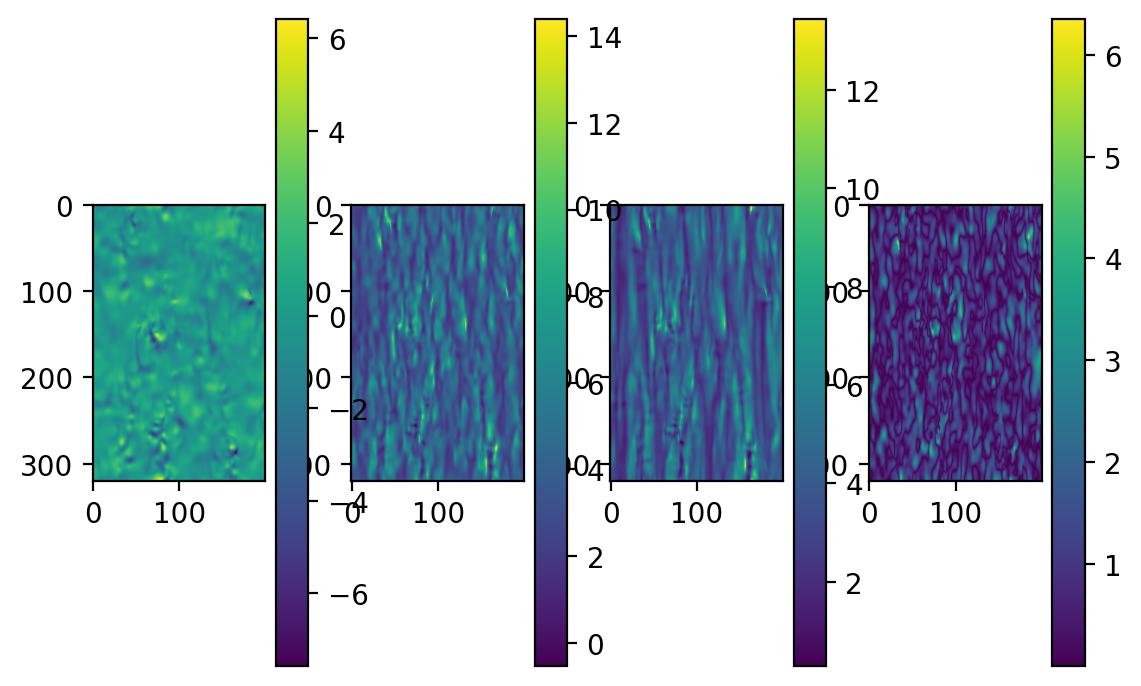

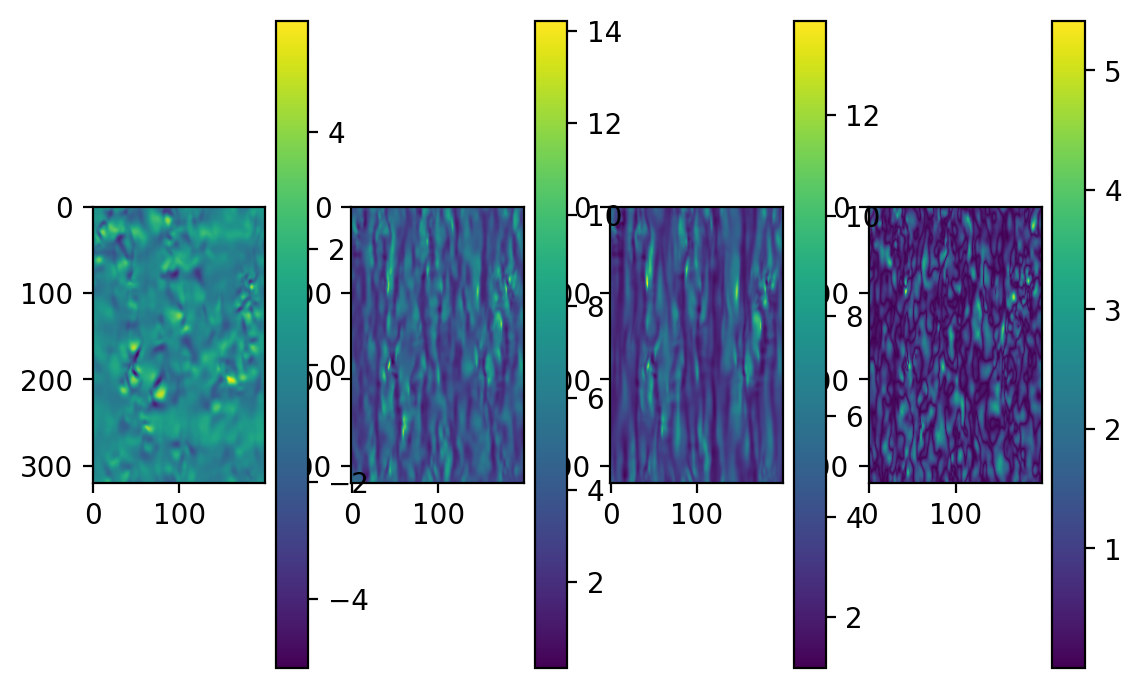

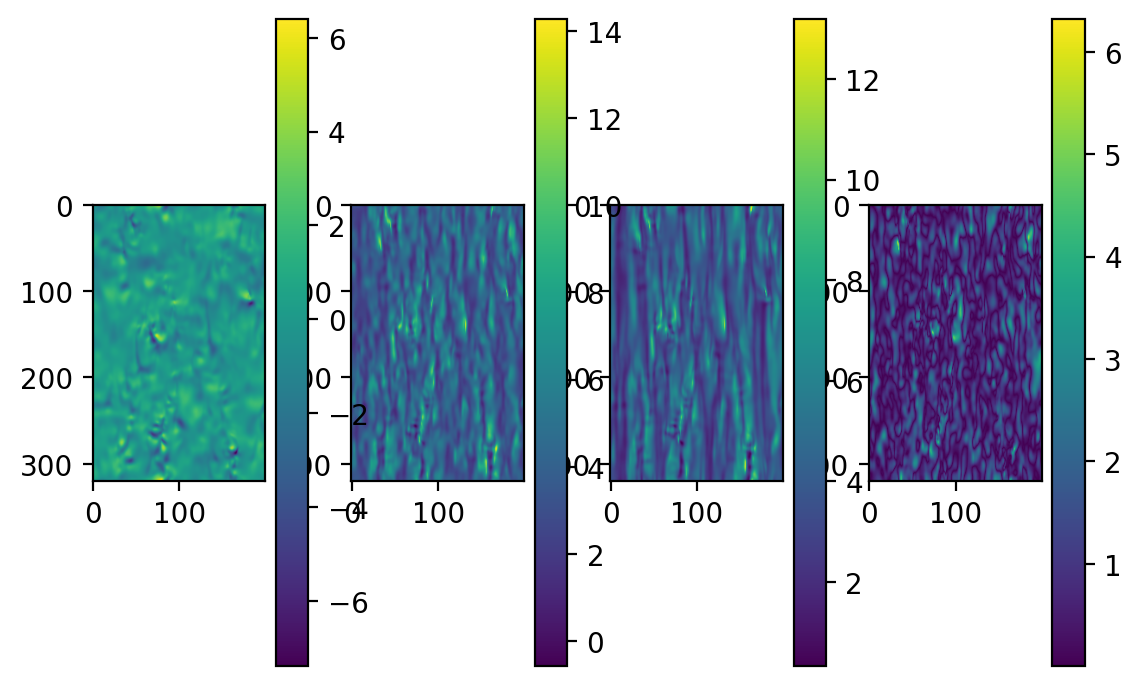

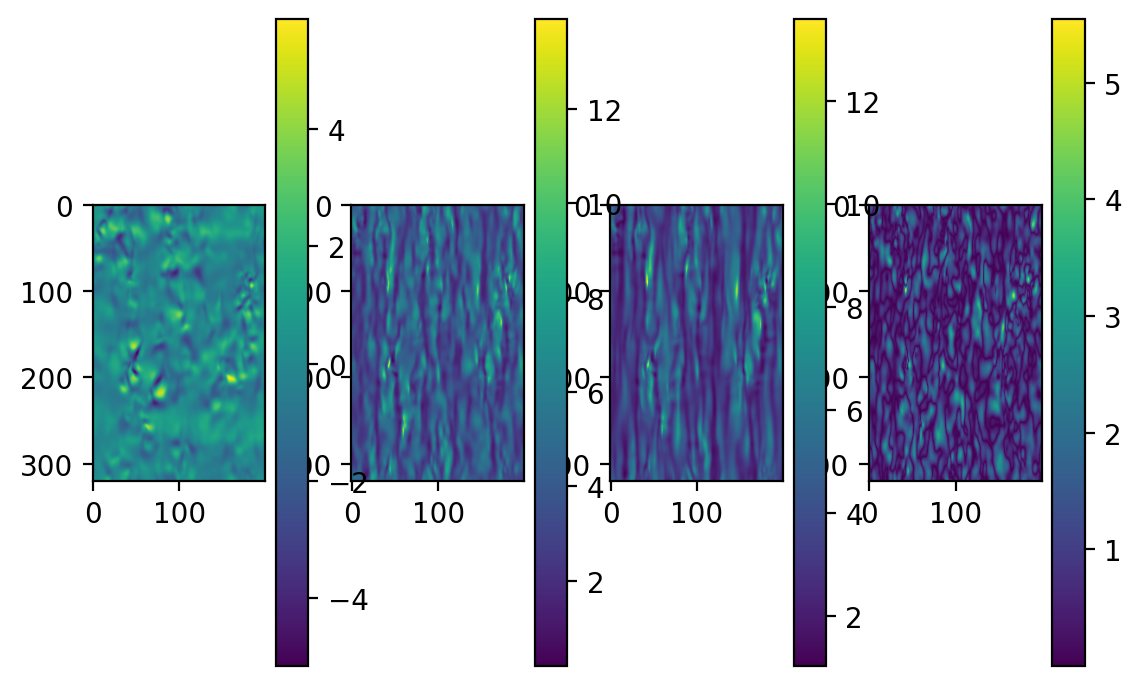

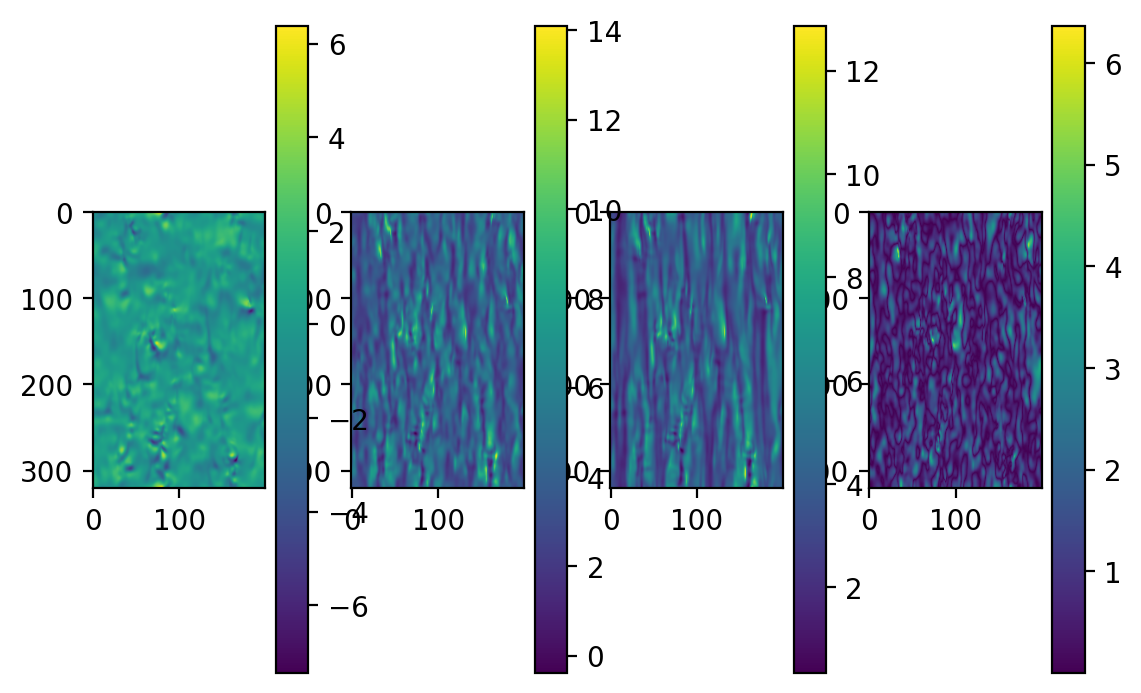

In [21]:
for i in range(5):
    fig, axes = plt.subplots(nrows=1, ncols=4, dpi=200)
    ax = axes[0].imshow(X[i])
    plt.colorbar(ax,ax=axes[0])
    ax = axes[1].imshow(samples[i,0])
    plt.colorbar(ax,ax=axes[1])
    ax= axes[2].imshow(test_label[i])
    plt.colorbar(ax,ax=axes[2])
    ax = axes[3].imshow(np.abs(samples[i,0] - test_label[i]))
    plt.colorbar(ax,ax=axes[3])

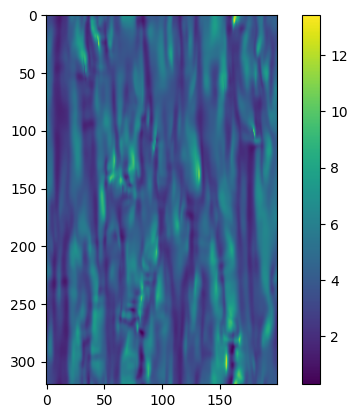

In [21]:
plt.imshow(test_label[0])
plt.colorbar()